# Downside!

In [3]:
import pandas as pd
import edhec_risk_kit as erk
%load_ext autoreload
%autoreload 2

In [4]:
hfi = erk.get_hfi_returns()

## Semideviation

In [5]:
# first we compute the usual standard deviation of returns
hfi.std(ddof=0)

Convertible Arbitrage     0.016706
CTA Global                0.022718
Distressed Securities     0.018084
Emerging Markets          0.032599
Equity Market Neutral     0.008181
Event Driven              0.019008
Fixed Income Arbitrage    0.011427
Global Macro              0.014609
Long/Short Equity         0.020834
Merger Arbitrage          0.011441
Relative Value            0.011829
Funds Of Funds            0.016030
dtype: float64

In [6]:
# to calculate the standard deviations of only the negative returns, a.k.a semideviation
hfi[hfi<0].std(ddof=0)

Convertible Arbitrage     0.020130
CTA Global                0.012199
Distressed Securities     0.017574
Emerging Markets          0.028596
Equity Market Neutral     0.009266
Event Driven              0.019643
Fixed Income Arbitrage    0.017645
Global Macro              0.006666
Long/Short Equity         0.015275
Merger Arbitrage          0.012358
Relative Value            0.013551
Funds Of Funds            0.013161
dtype: float64

We will define a new function for the semideviation and add it to the erk module

In [7]:
# testing the function now
erk.semideviation(hfi)

Convertible Arbitrage     0.020130
CTA Global                0.012199
Distressed Securities     0.017574
Emerging Markets          0.028596
Equity Market Neutral     0.009266
Event Driven              0.019643
Fixed Income Arbitrage    0.017645
Global Macro              0.006666
Long/Short Equity         0.015275
Merger Arbitrage          0.012358
Relative Value            0.013551
Funds Of Funds            0.013161
dtype: float64

## VaR and CVaR

### Value at Risk
- Historic VaR
- Parametric VaR (Gaussian)
- Modified Cornish-Fisher VaR

Historic VaR

In [8]:
import numpy as np
np.percentile(hfi, 5, axis=0) #5th percentile on each column of the hfi dataframe

array([-0.01499 , -0.03147 , -0.01977 , -0.042305, -0.00834 , -0.025505,
       -0.007155, -0.014935, -0.026205, -0.01064 , -0.01141 , -0.020305])

From the above result, it says, for example, that there is a 5% chance that in any given month you lose at least 1.499% from the Convertible Arbitrage strategy.
We will define a function that produces the results in a neater tabular format and add this function to the module erk

In [11]:
def var_historic(r, level=5):
    """
    VaR Historic
    """
    if isinstance(r, pd.DataFrame):
        return r.aggregate(var_historic,level=level)
    elif isinstance(r, pd.Series):
        return -np.percentile(r, level) # so that the results are output as positive numbers
    else:
        raise TypeError("Expected r to be a Series or DataFrame")

In [12]:
var_historic(hfi)

Convertible Arbitrage     0.014990
CTA Global                0.031470
Distressed Securities     0.019770
Emerging Markets          0.042305
Equity Market Neutral     0.008340
Event Driven              0.025505
Fixed Income Arbitrage    0.007155
Global Macro              0.014935
Long/Short Equity         0.026205
Merger Arbitrage          0.010640
Relative Value            0.011410
Funds Of Funds            0.020305
dtype: float64

In [13]:
erk.var_historic(hfi) #testing out the new function in the module erk

Convertible Arbitrage     0.014990
CTA Global                0.031470
Distressed Securities     0.019770
Emerging Markets          0.042305
Equity Market Neutral     0.008340
Event Driven              0.025505
Fixed Income Arbitrage    0.007155
Global Macro              0.014935
Long/Short Equity         0.026205
Merger Arbitrage          0.010640
Relative Value            0.011410
Funds Of Funds            0.020305
dtype: float64

Parametric VaR

Here we treat the return distribution as if it were Gaussian

In [14]:
# we'll try out the 'norm' function of scipy.stats
from scipy.stats import norm

In [16]:
z = norm.ppf(0.05)  #percentage point function, ie z-score at 5% level, ie distance of the 5% level from the mean of the normal distribution

In [17]:
z

-1.6448536269514729

In [18]:
-(hfi.mean() + z*hfi.std(ddof=0)) #specifying how many std dev away from the mean, this is the parametric VaR (Gaussian)

Convertible Arbitrage     0.021699
CTA Global                0.033084
Distressed Securities     0.022909
Emerging Markets          0.046880
Equity Market Neutral     0.009127
Event Driven              0.024606
Fixed Income Arbitrage    0.014391
Global Macro              0.018491
Long/Short Equity         0.027569
Merger Arbitrage          0.013250
Relative Value            0.013735
Funds Of Funds            0.021859
dtype: float64

We will write a function for the above parametric VaR calculation and add it to the erk module

In [19]:
erk.var_gaussian(hfi)

Convertible Arbitrage     0.021699
CTA Global                0.033084
Distressed Securities     0.022909
Emerging Markets          0.046880
Equity Market Neutral     0.009127
Event Driven              0.024606
Fixed Income Arbitrage    0.014391
Global Macro              0.018491
Long/Short Equity         0.027569
Merger Arbitrage          0.013250
Relative Value            0.013735
Funds Of Funds            0.021859
dtype: float64

Cornish-Fisher VaR

We will make a modification to the code for the Gaussian VaR in the erk module. Modified=True will trigger Cornish-Fisher

<Axes: title={'center': 'EDHEC Hedge Fund Indices: Value at Risk'}>

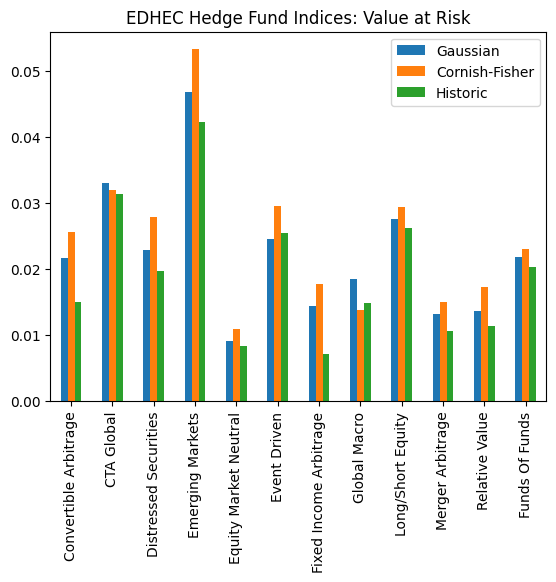

In [20]:
# we will compare the results of the three methods of computing VaR
var_list = [erk.var_gaussian(hfi), erk.var_gaussian(hfi, modified=True), erk.var_historic(hfi)]
comparison = pd.concat(var_list, axis=1) #create a dataframe with one row showing the VaR calculations
comparison.columns = ["Gaussian", "Cornish-Fisher", "Historic"]
comparison.plot.bar(title="EDHEC Hedge Fund Indices: Value at Risk")

## Beyond VaR, aka CVaR

In [21]:
#CVaR is the average of all the losses that are worse than the VaR, see function defined in erk module
erk.cvar_historic(hfi)

Convertible Arbitrage     0.038780
CTA Global                0.040620
Distressed Securities     0.041320
Emerging Markets          0.075447
Equity Market Neutral     0.017520
Event Driven              0.044453
Fixed Income Arbitrage    0.029067
Global Macro              0.021093
Long/Short Equity         0.044813
Merger Arbitrage          0.023333
Relative Value            0.027127
Funds Of Funds            0.035693
dtype: float64